# Bivariate linear regression

In this tutorial, we introduce the bivariate linear regression based PSM in `cfr`.

In [1]:
%load_ext autoreload
%autoreload 2

import cfr
print(cfr.__version__)
import pandas as pd
import numpy as np

## Data preparation

### Proxy

In [3]:
pdb = cfr.ProxyDatabase().fetch('PAGES2kv2')

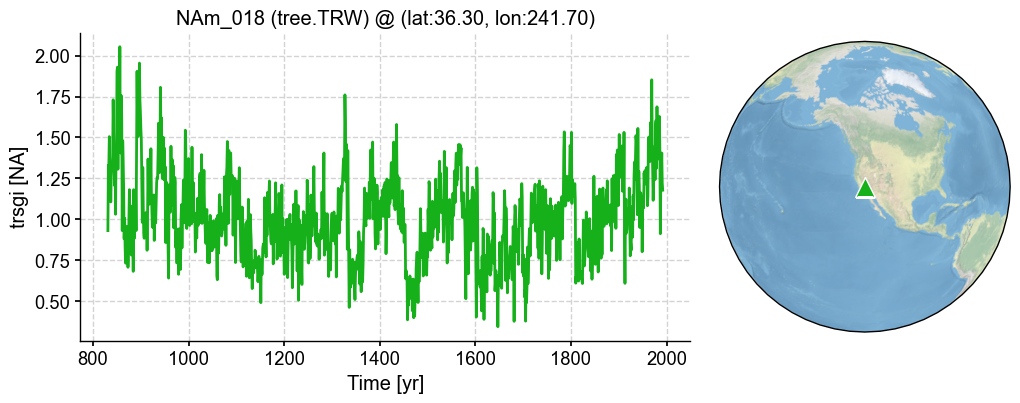

In [4]:
pobj = pdb.records['NAm_018']
fig, ax = pobj.plot()

### Model

In [5]:
model_tas = cfr.ClimateField().fetch('iCESM_past1000historical/tas')
model_pr = cfr.ClimateField().fetch('iCESM_past1000historical/pr')

>>> The target file seems existed at: ./data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc . Loading from it instead of downloading ...
>>> The target file seems existed at: ./data/pr_sfc_Amon_iCESM_past1000historical_085001-200512.nc . Loading from it instead of downloading ...


### Instrumental observations

In [6]:
obs_tas = cfr.ClimateField().fetch('CRUTSv4.07/tas', vn='tmp')
obs_pr = cfr.ClimateField().fetch('CRUTSv4.07/pr', vn='pre')

>>> The target file seems existed at: ./data/cru_ts4.07.1901.2022.tmp.dat.nc.gz . Loading from it instead of downloading ...
>>> The target file seems existed at: ./data/cru_ts4.07.1901.2022.pre.dat.nc.gz . Loading from it instead of downloading ...


In [7]:
obs_pr = obs_pr.rename('pr')
obs_tas = obs_tas.rename('tas')

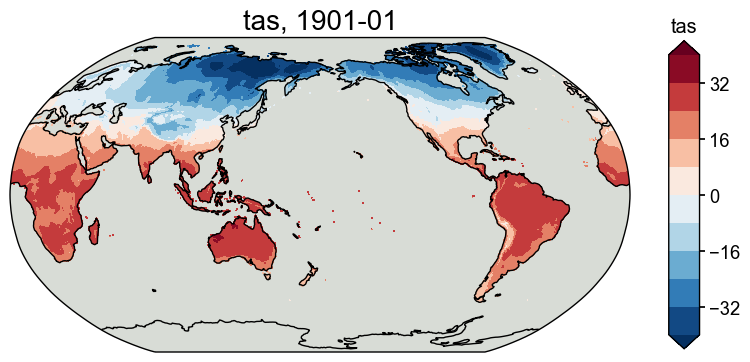

In [8]:
fig, ax = obs_tas.plot(levels=np.linspace(-40, 40, 11))

## Get climate data for a specific `ProxyRecord`

In [15]:
%%time

pobj.del_clim()
pobj.get_clim(model_tas, tag='model')
pobj.get_clim(model_pr, tag='model')
pobj.get_clim(obs_tas, tag='obs')
pobj.get_clim(obs_pr, tag='obs')

CPU times: user 8.94 ms, sys: 195 ms, total: 204 ms
Wall time: 2.31 s


In [17]:
pobj.clim['obs.tas'].da

<xarray.DataArray 'tas' (time: 1464)>
array([ 0.8       ,  0.90000004,  2.2       , ..., 11.1       ,
        1.7       ,  0.3       ], dtype=float32)
Coordinates:
    lon      float32 241.8
    lat      float32 36.25
  * time     (time) object 1901-01-16 00:00:00 ... 2022-12-16 00:00:00
Attributes:
    long_name:                   near-surface temperature
    units:                       degrees Celsius
    correlation_decay_distance:  1200.0

## Create a PSM object

In [18]:
lr_mdl = cfr.psm.Bilinear(pobj)

In [19]:
%%time
sn_list = [
    [1,2,3,4,5,6,7,8,9,10,11,12],
    [6,7,8],
    [3,4,5,6,7,8],
    [6,7,8,9,10,11],
    [-12,1,2],
    [-9,-10,-11,-12,1,2],
    [-12,1,2,3,4,5]
]
lr_mdl.calibrate(season_list1=sn_list, season_list2=sn_list)

CPU times: user 892 ms, sys: 210 ms, total: 1.1 s
Wall time: 1.1 s


In [20]:
lr_mdl.calib_details

{'df':         proxy       tas          pr
 time                               
 1901.0  1.518  0.850000  117.650002
 1902.0  1.321  4.700000   33.600002
 1903.0  1.271  3.583333   40.266666
 1904.0  1.257  4.883334   41.416668
 1905.0  1.328  5.500000   45.683338
 ...       ...       ...         ...
 1988.0  1.212  5.016666   73.533333
 1989.0  1.293  4.600000   31.683332
 1990.0  1.405  4.200000   28.316668
 1991.0  1.221  4.833333   15.250000
 1992.0  1.178  5.450000   59.683334
 
 [92 rows x 3 columns],
 'nobs': 92.0,
 'fitR2adj': 0.23768576931530339,
 'PSMresid': time
 1901.0    0.187140
 1902.0    0.134856
 1903.0    0.140399
 1904.0    0.012674
 1905.0    0.009239
             ...   
 1988.0   -0.220171
 1989.0    0.125670
 1990.0    0.289251
 1991.0    0.124874
 1992.0   -0.213713
 Length: 92, dtype: float64,
 'PSMmse': 0.0381896653537088,
 'SNR': 0.5841862240481599,
 'seasonality': ([-9, -10, -11, -12, 1, 2], [-9, -10, -11, -12, 1, 2])}

In [21]:
%%time
pp = lr_mdl.forward()

CPU times: user 247 ms, sys: 74.8 ms, total: 322 ms
Wall time: 318 ms


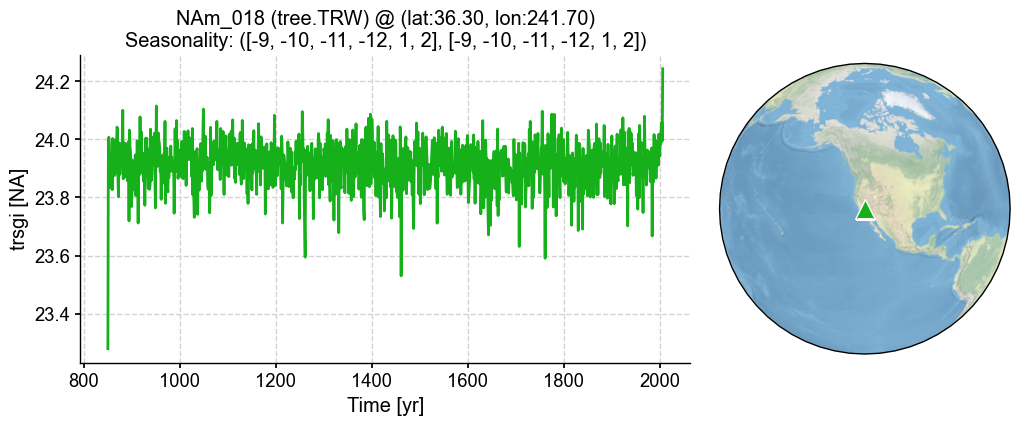

In [22]:
fig, ax = pp.plot()